## Assignment 3

### **Part 1: Tunneling in the Double Well Potential**

### Problem 1A

In [27]:
import os
os.makedirs('figs/', exist_ok=True)

woowwee

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize as opt
import tqdm.notebook as tqdm

#### Code from Assignment 2.

In [16]:
# code from Assignment 2
ALPHA = 0.40
XMIN = np.sqrt(1 / ALPHA)
OMEGA = np.sqrt(8 * ALPHA * XMIN ** 2)
XSTART = XMIN
BOXSIZE = 8
ND = 600
DELTA_X = BOXSIZE / ND
HBAR = 1
T0 = 20 * np.pi
DELTA_T = np.pi / 128
NT = int(T0 / DELTA_T)

t = np.linspace(0, T0, NT + 1)
x = np.linspace(-BOXSIZE / 2, BOXSIZE / 2, ND + 1)

def V(x, alpha=.4):
    return -2*x**2 + alpha*x**4 + 1/alpha

def psi_0(x, x_start, omega=OMEGA):
    part1 = (omega / np.pi) ** (1 / 4)
    part2 = np.exp(-( omega / (2 * HBAR)) * (x - x_start)**2)
    return part1 * part2

def k_dt(x, dt, alpha=.4):
    x_g = np.meshgrid(x, x)
    exponent = 1j * (0.5 * (x_g[1] - x_g[0])**2 / dt - V((x_g[0] + x_g[1]) / 2, alpha=alpha) * dt)
    return np.exp(exponent)

def cos(x, A, omega, phi):
    return A * np.cos(omega*x-phi)

def partsAandB(a):
    XMIN = np.sqrt(1 / a)
    OMEGA = np.sqrt(8 * a * XMIN ** 2)
    XSTART = XMIN

    K_DT = k_dt(x, DELTA_T, alpha=a)

    PSI_0 = psi_0(x, XSTART, omega=OMEGA)
    PSI = np.zeros((NT+1, PSI_0.shape[0]), dtype=np.complex64)
    PSI[0] = PSI_0

    for i in range(NT):
        PSI[i+1] = DELTA_X * np.matmul(K_DT, PSI[i])
        PSI[i+1] /= np.sqrt(DELTA_X * np.sum(PSI[i+1] * PSI[i+1].conjugate()))

    prob = np.real(PSI * np.conjugate(PSI))
    X_BAR = np.sum(prob*x*DELTA_X, axis=1)

    #CORRECTION: this is where I added bounds to the fittment
    (A, omega, phi),_ = opt.curve_fit(cos, t, X_BAR, p0 = [1.3, 0.1, 0.0], bounds=([0.8, 0.05, -0.5],[2., 0.5, 0.5]))

    TUNNELING_TIME = (np.pi+phi)/omega

    H_kenetic = np.eye(ND+1)*(-2) + np.eye(ND+1, k=1) + np.eye(ND+1, k=-1)
    H_kenetic *= (-.5/(DELTA_X**2))
    V_x = V(x, alpha=a)
    H_potential = V_x * np.eye(ND+1)
    H = H_kenetic + H_potential

    Es, psis = scipy.sparse.linalg.eigsh(H, k=2, sigma=0, which='LM')
    delta_E = Es[1]-Es[0]

    return (TUNNELING_TIME, delta_E, Es, H)

Here are the results from my prior work on Assignment 2:

In [17]:
tunneling_time, prior_deltaE, prior_Es, H = partsAandB(0.40)
prior_Es, prior_deltaE

(array([1.23447724, 1.34690427]), 0.11242703776659502)

#### Find the ground state and first excited state using the power method to determine smallest eigenvectors and eigenvalues

In [18]:
#this removes the dominant eigenvalue lamba0 & eigenvector v0 from matrix A
def deflate(A, lambda_0, v_0):
  n = A.shape[0]
  w = v_0 / (np.dot(v_0.T, v_0))
  return A - lambda_0 * np.outer(v_0, w)

#this method is ment to handle complex numbers 
def deflate_complex(A, lambda1, v_0):
  v_0 = np.atleast_2d(v_0).T  #reshape v1 to a column vector if it's not already
  #use conjugate transpose for w
  w_h = np.conjugate(v_0.T)

  #check if w_h @ v1 == 1 and adjust if necessary
  normalization_factor = w_h @ v_0
  if normalization_factor != 1:
    w_h = w_h / normalization_factor

  #perform the rank-one update for complex numbers
  A_prime = A - lambda1 * (v_0 @ w_h)
  return A_prime

#based on https://jduarte.physics.ucsd.edu/phys142/labs/lab9/Lab9.html
def power_method(H, k=1, n_iter = 100):

  Hinv = scipy.linalg.inv(H)

  for j in range(k):
    u = [np.ones(ND + 1)]
    lambda_0 = [np.dot(u[-1].conjugate(), H @ u[0]) / np.dot(u[-1].conjugate(), u[0])]
    for i in range(n_iter):
      u.append(Hinv @ u[-1])
      u[-1] /= (np.sum(u[-1].conjugate() * u[-1]) * DELTA_X)
      lambda_0.append(np.dot(u[-1].conjugate(), H @ u[-1]) / np.dot(u[-1].conjugate(), u[-1]))
    if (j == k-1):
      return lambda_0, u[-1], i+1
    else:
      #deflate the inverted matrix to remove dominant eigenvalue
      Hinv = deflate_complex(Hinv, lambda_0[-1], u[-1]) 

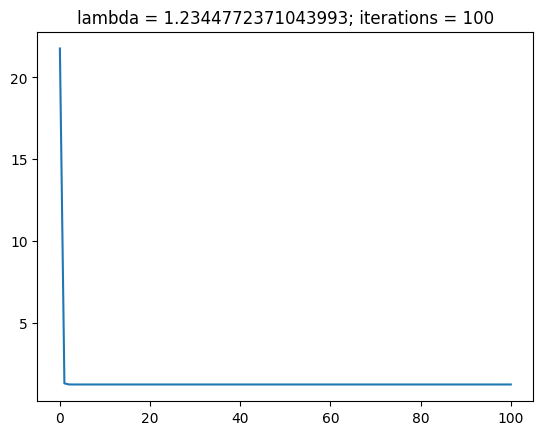

In [20]:
#check for convergence
lambdas_0, phi_0, i_0 = power_method(H, k=1)
plt.plot(lambdas_0)
plt.title('lambda = ' + str(lambdas_0[-1]) + '; iterations = ' + str(i_0))
plt.show()

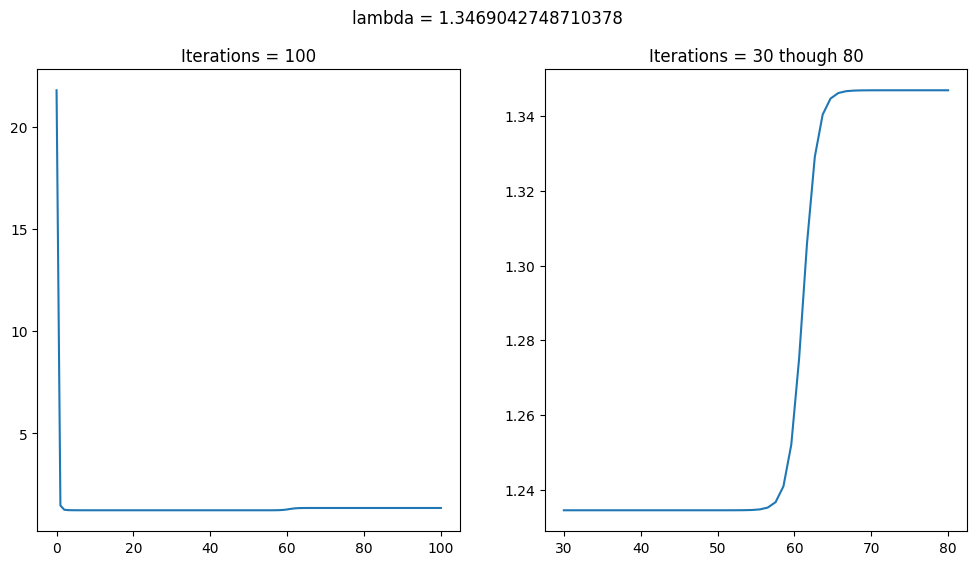

In [21]:
# check for convergence / it takes extra looping to find dominant value
lambdas_1, phi_1, i_1 = power_method(H, k=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('lambda = ' + str(lambdas_1[-1]))

ax1.plot(lambdas_1)
ax1.set_title('Iterations = 100')
ax2.plot(np.linspace(30,80,50), lambdas_1[30:80]) # zoom in to see convergence
ax2.set_title('Iterations = 30 though 80')
plt.show()

Notice the small bump in the answer arund the 60th itteration, this is where the answer converges to the correct value. 

In [22]:
deltaE = lambdas_1[-1] - lambdas_0[-1]
print('lowest energy state = ', lambdas_0[-1], '; next lowest = ', lambdas_1[-1], '; delta E = ', deltaE)

lowest energy state =  1.2344772371043993 ; next lowest =  1.3469042748710378 ; delta E =  0.11242703776663854


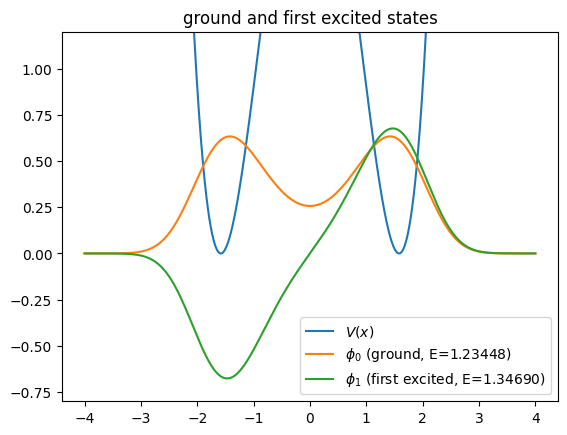

In [23]:
# normalize wave funcions
phi_0 /= np.sqrt(np.sum(phi_0.conjugate() * phi_0) * DELTA_X)
phi_1 /= np.sqrt(np.sum(phi_1.conjugate() * phi_1) * DELTA_X)

plt.plot(x, V(x), label='$V(x)$')
plt.plot(x, phi_0, label='$\phi_0$ (ground, E=' + '{0:.5f}'.format(lambdas_0[-1]) + ')')
plt.plot(x, phi_1, label='$\phi_1$ (first excited, E=' + '{0:.5f}'.format(lambdas_1[-1]) + ')')
plt.ylim(-.8,1.2)
plt.legend()
plt.title('ground and first excited states')
plt.show()

#### Expected Tunneling Time (compared to Banerjee)

In [11]:
prior_time = 27.95777271750949 #from assignment 2 
print('estimated tunneling time is:    ', tunneling_time)
print('from prior assignment:          ', prior_time)
print('  difference:                   ', tunneling_time - prior_time)
print('from Banerjee:                  ', 27.94)
print('  difference:                   ', np.round(tunneling_time-27.94, 2))
print('(all times in seconds)')

estimated tunneling time is:     27.95777612735555
from prior assignment:           27.95777271750949
  difference:                    3.409846062396582e-06
from Banerjee:                   27.94
  difference:                    0.02
(all times in seconds)


#### Energies and $\Delta E$ (compared to prior assignment and Banerjee)

Note: In assignment 2, I performed an approximately equivalent calculation to the power method (above) using the scipy library:

```
    H_kenetic = np.eye(ND+1)*(-2) + np.eye(ND+1, k=1) + np.eye(ND+1, k=-1)
    H_kenetic *= (-.5/(DELTA_X**2))
    V_x = V(x, alpha=a)
    H_potential = V_x * np.eye(ND+1)
    H = H_kenetic + H_potential

    Es, psis = scipy.sparse.linalg.eigsh(H, k=2, sigma=0, which='LM')
    delta_E = Es[1]-Es[0]
```

I asked Professor Duarte if I needed to use the approxamation in the corrections of last assignment, but he told me to leave my code as is and explain my approach in a note. This accounts for not seeing substantial differences between assignment 2 and assignment 3. Otherwise, I would find that this result differs from assignment 2 by roughly a factor of 10 (based on the numbers publised in assignment 2 solutions). 

In [13]:
print('differences from prior results (assignment 2)')
print('  diffrences of two lowest energy states: ', (lambdas_0[-1] - prior_Es[0], lambdas_1[-1] - prior_Es[1]))
print('  diffrence in delta E: ', deltaE - prior_deltaE)

differences from prior results (assignment 2)
  diffrences of two lowest energy states:  (-3.064215547965432e-14, 1.2878587085651816e-14)
  diffrence in delta E:  4.3520742565306136e-14


Note that this diffrence is on the order of percitrion of a float, so the methods must be consitered equivlent. 

In [14]:
print('differences from Banerjee')
print('  two lowest energy states: ', (np.round(lambdas_0[-1],4) - 1.2345, np.round(lambdas_1[-1],4) - 1.3469))
print('  deltaE: ', np.round(deltaE, 4) - 0.1124)

differences from Banerjee
  two lowest energy states:  (0.0, 0.0)
  deltaE:  0.0


Again, within precision, the diffrence is negligable.

### Problem 1B

Equation 1
$$\psi(x,t=0)=\frac{1}{\sqrt 2}(\phi_0(x)+\phi_1(x))$$

Equation 2
$$\psi(x,t)=\frac{1}{\sqrt 2}(e^{-iE_0t/\hbar}\phi_0(x)+e^{-iE_1t/\hbar}\phi_1(x))$$

Note: equations are equivalent at t=0

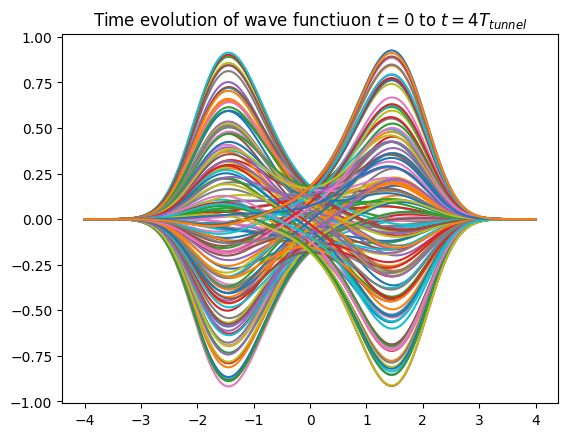

In [15]:
X = [i for i in range(ND+1)] # allows indexing into phi across x
T = np.linspace(0.0, tunneling_time * 4, int(tunneling_time*4/(DELTA_T*32)))

#don't want to use a condational for t=0 because that would prevent vectorization
def wave(x, t, E0, E1, phi0, phi1, hbar):
  return (1/(2**(1/2))) * (np.exp(-1j * E0 * t / hbar)*phi0[x] + np.exp(-1j * E1 * t / hbar)*phi_1[x])

for t in T:
  w = wave(X, t, lambdas_0[-1], lambdas_1[-1], phi_0, phi_1, HBAR)
  plt.plot(x, np.real(w))

plt.title('Time evolution of wave functiuon $t=0$ to $t=4T_{tunnel}$')
plt.show()

I'm not hugely fond of the appearance of this plot, but if I decreace the multiple of DELTA_T (line 2) more that this, the extreme values of the eviluation begin to disapear. Below, I will show time on a seprate axis, which is perhaps somewhat eaysier to look at.

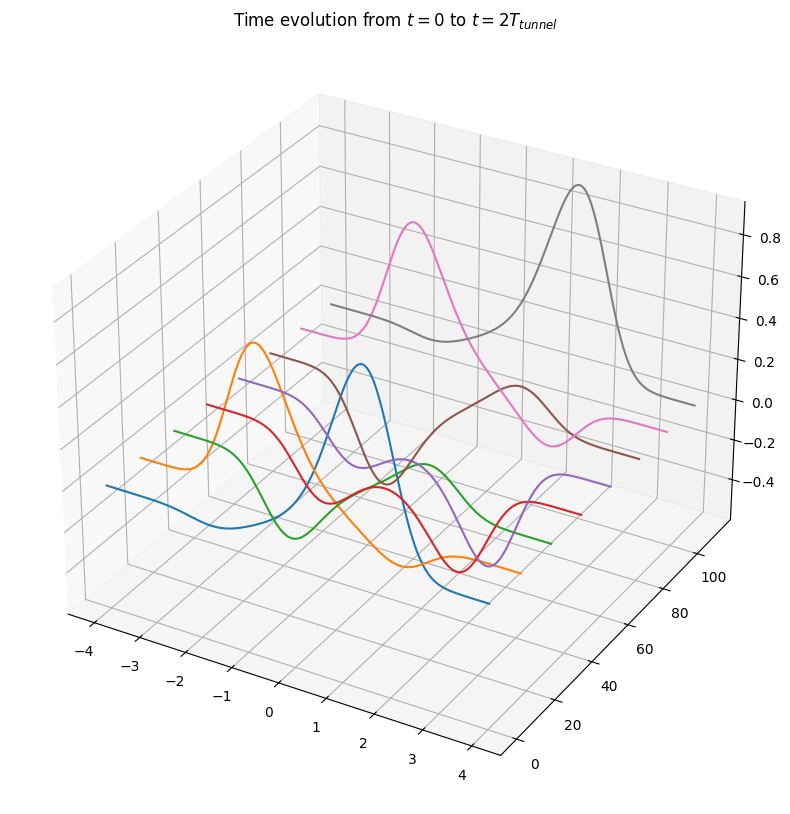

In [16]:
# try again in 3d with shorter time frame
# this is easier to visualize
T = np.linspace(0.0, tunneling_time * 4, int(tunneling_time*2/(DELTA_T*256)))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for t in T:
  w = wave(X, t, lambdas_0[-1], lambdas_1[-1], phi_0, phi_1, HBAR)
  ax.plot(x, np.ones(len(X))*t, np.real(w))

plt.title('Time evolution from $t=0$ to $t=2T_{tunnel}$')
plt.show()

This doesen't show all features, but the sparseness makes it much eaysier to understand. Reguardless, the animation is more illuminating than either plot.

### Problem 1C

In [17]:
SAMPLE = 16  #rate of frames selected from animation code (from assingment 2)

In [18]:
# code from Assignment 2 reduced to finding wave function
ALPHA = 0.40
XMIN = np.sqrt(1 / ALPHA)
OMEGA = np.sqrt(8 * ALPHA * XMIN ** 2)
XSTART = XMIN
BOXSIZE = 8
ND = 600
DELTA_X = BOXSIZE / ND
HBAR = 1
T0 = tunneling_time * 4 #changed time frame
DELTA_T = np.pi / 128
NT = int(T0 / DELTA_T)

t = np.linspace(0, T0, NT + 1)
x = np.linspace(-BOXSIZE / 2, BOXSIZE / 2, ND + 1)

def V(x, alpha=.4):
    return -2*x**2 + alpha*x**4 + 1/alpha

def psi_0(x, x_start, omega=OMEGA):
    part1 = (omega / np.pi) ** (1 / 4)
    part2 = np.exp(-( omega / (2 * HBAR)) * (x - x_start)**2)
    return part1 * part2

def k_dt(x, dt, alpha=.4):
    x_g = np.meshgrid(x, x)
    exponent = 1j * (0.5 * (x_g[1] - x_g[0])**2 / dt - V((x_g[0] + x_g[1]) / 2, alpha=alpha) * dt)
    return np.exp(exponent)

def cos(x, A, omega, phi):
    return A * np.cos(omega*x-phi)

def feynman_wave():
    XMIN = np.sqrt(1 / ALPHA)
    OMEGA = np.sqrt(8 * ALPHA * XMIN ** 2)
    XSTART = XMIN

    K_DT = k_dt(x, DELTA_T)

    PSI_0 = psi_0(x, XSTART, omega=OMEGA)
    PSI = np.zeros((NT+1, PSI_0.shape[0]), dtype=np.complex64)
    PSI[0] = PSI_0

    for i in range(NT):
        PSI[i+1] = DELTA_X * np.matmul(K_DT, PSI[i])
        PSI[i+1] /= np.sqrt(DELTA_X * np.sum(PSI[i+1] * PSI[i+1].conjugate()))

    return PSI

In [19]:
fw = feynman_wave()
fw *= fw.conjugate()
fw.shape

(4557, 601)

In [20]:
fw[::SAMPLE].shape # reduce frame count by sampling nth frame

(285, 601)

Text(0.5, 1.0, 'sample Feynman proability')

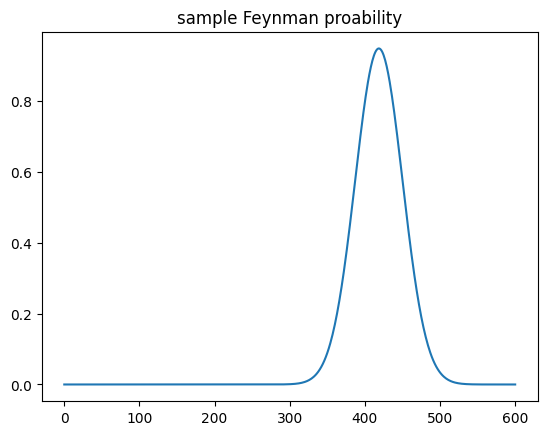

In [21]:
# a plot to check my work looks good so far
plt.plot(np.real(fw[::SAMPLE][0]))
plt.title('sample Feynman proability')

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

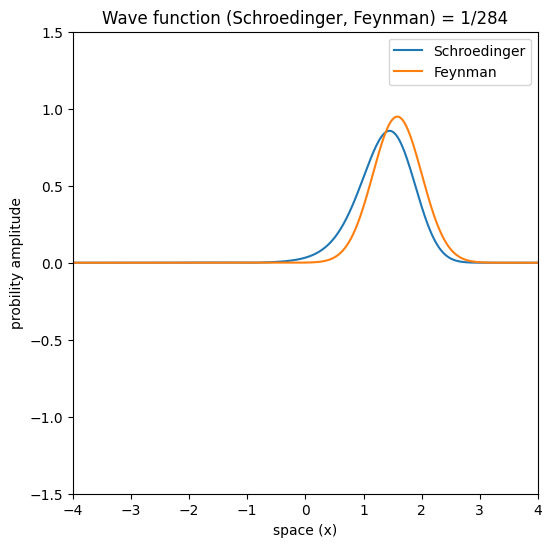

In [22]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

'''
increase frames (reduce timestep) on a bigger computer
'''
T = np.linspace(0.0, tunneling_time * 4, int(tunneling_time*4/(DELTA_T*SAMPLE)))
sw = np.array([wave(X, t, lambdas_0[-1], lambdas_1[-1], phi_0, phi_1, HBAR) for t in T])
sw *= sw.conjugate()

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-BOXSIZE/2,BOXSIZE/2)

def update(frame):
    ax.clear()
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(-BOXSIZE/2,BOXSIZE/2)
    ax.set_xlabel('space (x)')
    ax.set_ylabel('probility amplitude')
    ax.plot(x, np.real(sw[frame]), label='Schroedinger')
    ax.plot(x, np.real(fw[::SAMPLE][frame]), label='Feynman')
    ax.set_title("Wave function (Schroedinger, Feynman) = "+f'{frame + 1}/{len(sw)}')
    ax.legend(loc='upper right')

ani = FuncAnimation(fig, update, frames=len(sw), interval=70)
ani.save('animation.mp4', writer='ffmpeg', fps=30)
HTML(ani.to_jshtml())

The Schrodinger approach has greater continuity. This makes sense because that approach depends only on continuos mathematical functions. The Feynman approach is discrete (it depends on the discrete propagator matrix) so it produces a less smooth result. In the limit as delta x goes to zero, the propagator matrix gets infinitly large, and the two results should converge.

## **Part 2: MCMC and 2D Ising Model**



Here is the code from the MCMC tutorial reorganized as functions.

In [2]:
# this should prevent floating point error
def random_spins(n):
  spins = np.random.randint(2, size = (n,n)) # random 0 or 1
  return np.where(spins, 1, -1) # the zeroes will evalute to false and become -1

random_spins(5)

array([[ 1,  1, -1,  1,  1],
       [-1,  1, -1,  1,  1],
       [ 1,  1, -1,  1,  1],
       [-1,  1,  1, -1, -1],
       [ 1, -1,  1,  1,  1]])

In [3]:
STEPS = 1_000_000
N = 20
J = 1
KB = 1
T = 2

#functionalized version of code presented in the MCMC tutorial
def spins(steps = STEPS, random = True, temp = T, size=N):
  if random:
    lattice_spins = random_spins(size)
  else:
    lattice_spins = np.ones((size,size))

  num_accept = 0
  m_values = []
  for t in tqdm.tqdm(range(steps)):
    i, j = np.random.randint(size), np.random.randint(size)
    # we only need to consider the neighbors of
    # (i, j) to calculate the change in energy
    delta_energy = 0
    for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
      i_neigh = i + k if i + k < N else 0
      j_neigh = j + l if j + l < N else 0
      delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
    if delta_energy <= 0:
      lattice_spins[i, j] *= -1
      num_accept += 1
    elif delta_energy > 0:
      prob = np.exp(-delta_energy / (KB * temp))
      if np.random.random() < prob:
        lattice_spins[i, j] *= -1
        num_accept += 1
    m_values.append(np.mean(lattice_spins))
  return m_values, lattice_spins, steps

In [4]:
#again, MCMC tout. code packaged into a function
def plot_lattice(lattice_spins):
  plt.figure()
  plt.imshow(lattice_spins, cmap="RdYlBu")
  # show gridlines
  for i in range(N):
      plt.axhline(i + 0.5, color="black", lw=0.1)
      plt.axvline(i + 0.5, color="black", lw=0.1)
  plt.show()

In [5]:
BURNIN = 100_000

#again
def plot_m(m_values, burn_in = BURNIN, temp = T):
  m_mean = np.mean(m_values[burn_in:])
  m_std = np.std(m_values[burn_in:])

  plt.figure()
  plt.plot(range(steps)[:burn_in], m_values[:burn_in], label="Burn in")
  plt.plot(range(steps)[burn_in:], m_values[burn_in:], label="Sampling")
  # show mean as dashed line
  plt.plot(range(steps), m_mean * np.ones((steps)), "--", color="black")
  # show variance as filled box
  plt.fill_between(range(steps), m_mean - m_std, m_mean + m_std, color="gray", alpha=0.3)
  plt.xlabel("Steps")
  plt.ylabel("Magnetization")
  plt.legend(title=f"T={temp}")
  plt.title(f"Burn in = {burn_in}; T = {temp}")
  plt.show()

  print(f"magnetization mean = {m_mean}")
  print(f"magnetization std = {m_std}")

### Problem A, Case 1: All spins up

  0%|          | 0/1000000 [00:00<?, ?it/s]

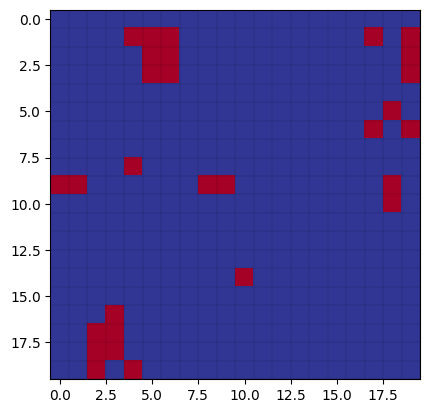

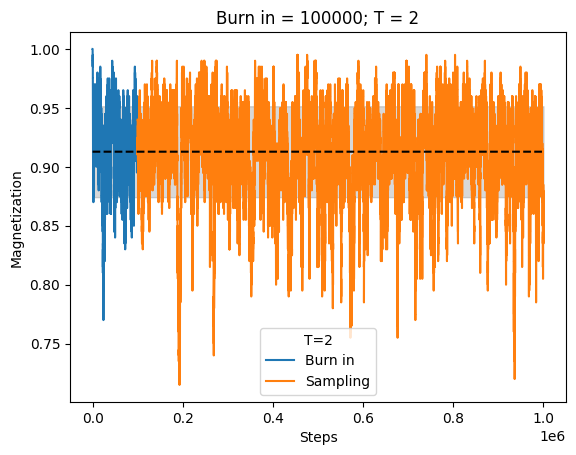

magnetization mean = 0.912825616666667
magnetization std = 0.03856315349034258


In [6]:
# round MC with all spins up
m_valuesUP, lattice_spins, steps = spins(steps=1_000_000, random=False)
plot_lattice(lattice_spins)
plot_m(m_valuesUP, burn_in = 100_000)

These results do not seem to converge, or do not need any burn in (these cases are indistinguishable). To atempt to distinguish between the possibilties (and therefore understand if my code is working), I must run another test. I will use a much higher tempature, and try to observe convergance.

  0%|          | 0/100000 [00:00<?, ?it/s]

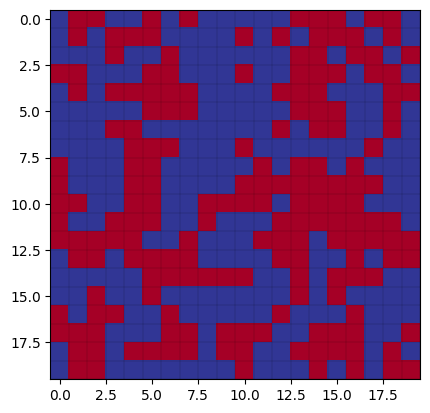

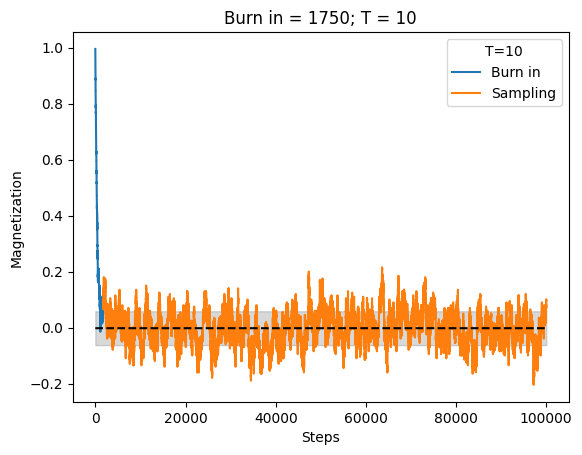

magnetization mean = -0.0024396946564885485
magnetization std = 0.06054690988900906


In [7]:
 # test with a high temperture
m_values, lattice_spins, steps = spins(steps=100000, random=False, temp=10)
plot_lattice(lattice_spins)
plot_m(m_values, burn_in=1750, temp=10)

That worked. Not only does it clearly converange, it does so in sevral orders of magnatude fewer itterations.

### Problem A, Case 2: Random initial spins

  0%|          | 0/1000000 [00:00<?, ?it/s]

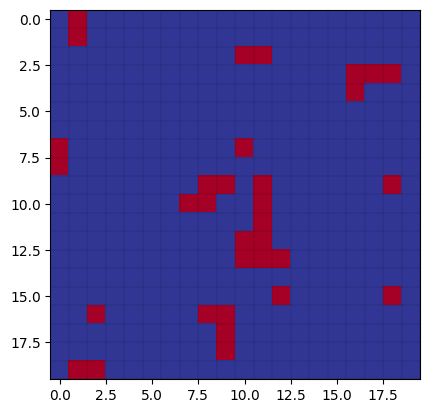

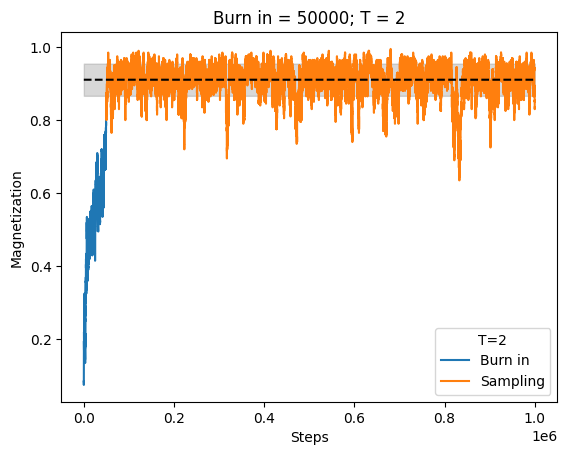

magnetization mean = 0.9106567000000001
magnetization std = 0.0440955551269298


In [8]:
m_valuesRAND, lattice_spins, steps = spins(steps=1_000_000, random=True)
plot_lattice(lattice_spins)
plot_m(m_valuesRAND, burn_in=50_000)

The burn in for the first case is very small, essentually the first time we can consiter our state to be independint from the inital state. I'll use 10% to be safe, but in theory, less would be acceptable. I think as few as 10 000 steps would previde good numbers.

By inspection of the results, I was able to get very simular mean and standard devation with the random start with as few as 50 000 steps in the burn-in. If I were not able compare to the results to the prior method and confirm that they are indeed the same, I would increace the amount of burn-in to increace reliability. 

To investagate the number of itterations to get a good magnitazation, lets look at slicing of the mean and standard devation. When these level off to a consistant value, the sample is of adaquate size.  

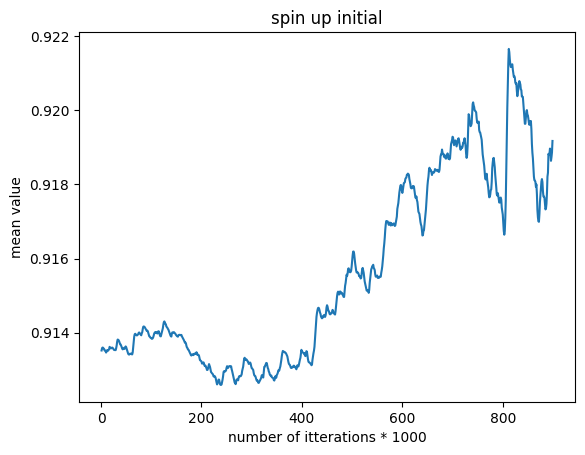

In [9]:
#slice backwards from the end of the data, being sure to avoid the first 10% (burn-in)
UP_mean = np.array([(x, np.mean(m_valuesUP[:-x*1000])) for x in range(1,900)])
plt.xlabel('number of itterations * 1000')
plt.ylabel('mean value')
plt.title('spin up initial')
plt.plot(UP_mean.T[0], UP_mean.T[1])

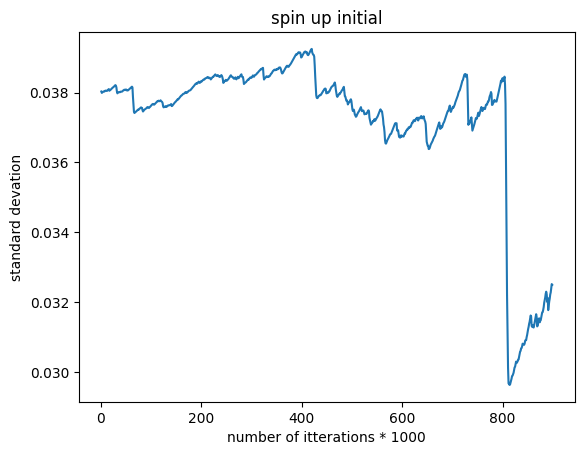

In [10]:
#same thing, but for the standard devation
UP_std = np.array([(x, np.std(m_valuesUP[:-x*1000])) for x in range(1,900)])
plt.xlabel('number of itterations * 1000')
plt.ylabel('standard devation')
plt.title('spin up initial')
plt.plot(UP_std.T[0], UP_std.T[1])

At the end of this standard devation graph, we see that I have run into the burn-in (because I am slicing backwards). This shows that my above answer was incorrect, I should use a longer burn-in even though it looks visually settled. Rougly 20% burn-in for the frist run. Also, the standard devation should decreace with a greator number of itterations, so these results look unstable. 

I can now do the same for the random inital state (just the standard devation because it is more informative). 

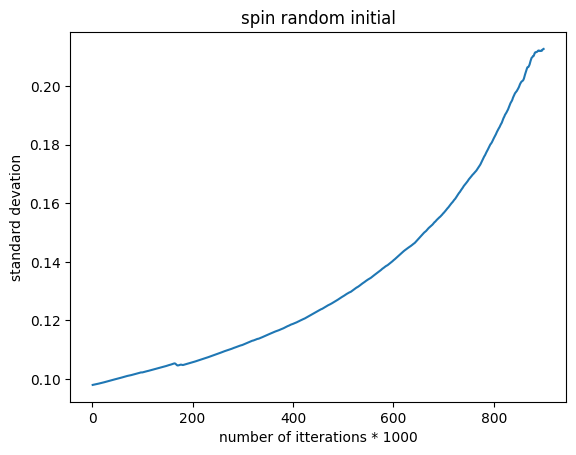

In [11]:
#same thing, but for the standard devation
RAND_std = np.array([(x, np.std(m_valuesRAND[:-x*1000])) for x in range(1,900)])
plt.xlabel('number of itterations * 1000')
plt.ylabel('standard devation')
plt.title('spin random initial')
plt.plot(RAND_std.T[0], RAND_std.T[1])

This looks more like I would expect, the standard devation steadaly decreaces with the number of runs. This sugests this method (random inital state) is in some way more stable. Thereofre I will use it in the next part of this question. 

A good number of total steps is 900 000 because for the duration of the graph, the results looks stable.

### Problem B

In [12]:
temps = np.linspace(1,4,16)
temps

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
       3.6, 3.8, 4. ])

In [13]:
def stats(T, n=1_000_000, burn_in=10000, size=N):
  m_values, _, __ = spins(steps=n, random=False, temp=T, size=N)
  return np.mean(m_values[burn_in:]), np.std(m_values[burn_in:])

In [14]:
# the initial condition of all spins up is computationally more efficint because it does not need to burn in
results = np.array([stats(temp, n=1_000_000, burn_in=100_000) for temp in temps])

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

[]

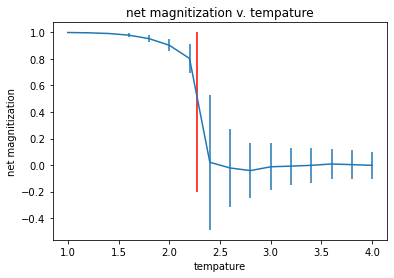

In [40]:
plt.errorbar(temps, results.T[0], yerr=results.T[1])
plt.vlines([2.269], ymin=-0.2, ymax=1.0, color='red')
plt.title('net magnitization v. tempature')
plt.xlabel('tempature')
plt.ylabel('net magnitization') 
plt.plot()

See the bottom of the above section for discussion of burn-in by investigateing the decreace in standard devation vs. number of itterations. I also discuss why the random inital state appears to me to be more stable, this is the reason I chose to use that above. As for other perameters, I had no rigerous reasoning, other than the results looking reasonable to justify my choices. I chose not to use thinning because the results appear to be roughly independent, judgeing by the smootheness of the standard devation curve at the bottom of problem A. 